In [1]:
import pandas as pd
import requests
import zipfile
import io
import os


url = "https://drive.google.com/uc?export=download&id=1FHp1opVOqcI_HU0HLPv4WRn8e4kEtuI7"
response = requests.get(url)
response.raise_for_status()  # raise an error if download fails


extract_dir = "Statics vs Dynamics"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(extract_dir)

data_frames = {}

for root, dirs, files in os.walk(extract_dir):
    for file_name in files:
        if file_name.endswith(".xlsx"):
            file_path = os.path.join(root, file_name)
            try:
                df = pd.read_excel(file_path)
                data_frames[file_name] = df
                print(f"Loaded: {file_name} with shape {df.shape}")
            except Exception as e:
                print(f"Could not load {file_name}: {e}")

if data_frames:
    first_key = next(iter(data_frames))
    print("\nPreview of first DataFrame:", first_key)
    print(data_frames[first_key].head())


Loaded: parameter_combinations_1.xlsx with shape (9, 5)
Loaded: parameter_combinations_2.xlsx with shape (9, 5)
Loaded: parameter_combinations_3.xlsx with shape (9, 5)
Loaded: parameter_combinations_4.xlsx with shape (9, 5)
Loaded: parameter_combinations_5.xlsx with shape (9, 5)
Loaded: parameter_combinations_6.xlsx with shape (9, 5)
Loaded: parameter_combinations_7.xlsx with shape (9, 5)
Loaded: parameter_combinations_8.xlsx with shape (9, 5)

Preview of first DataFrame: parameter_combinations_1.xlsx
           Noise Type  illusion 1  illusion 2  illusion 3  illusion 4
0  Dynamics_60fps_1px         4.5         4.0         4.5         4.0
1         Statics_1px         2.0         1.0         1.0         1.0
2        Statics_16px         1.0         1.0         1.0         1.0
3         Statics_1px         1.5         1.0         1.0         1.0
4  Dynamics_60fps_1px         3.0         3.0         3.5         3.5


In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15  # You can change the size to fit your needs

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import combinations

# =========================
# CONFIG
# =========================
columns_to_normalize = ['illusion 1', 'illusion 2', 'illusion 3', 'illusion 4']
noise_rename = {
    'Dynamics_60fps_1px': 'Dynamics_60fps_1cs',
    'Statics_1px':        'Statics_1cs',
    'Statics_16px':       'Statics_16cs',
}
valid_noise = ['Dynamics_60fps_1cs', 'Statics_1cs', 'Statics_16cs']

display_labels = [
    '1) Iconic trace of\n trajectory',
    '2) Repulsion/\nattraction',
    '3) Action capture\n (visible hand)',
    '4) Action Capture\n (invisible hand)'
]
label_map = dict(zip(columns_to_normalize, display_labels))
SHOW_NS = False       # draw only significant brackets by default
LBOUND, UBOUND = 0.0, 1.0

# =========================
# 1) Normalize (x−1)/6 within each file (1..7 -> 0..1)
# =========================
for key, df in data_frames.items():
    if key.startswith('parameter_combinations_') and key.endswith('.xlsx'):
        missing = [c for c in columns_to_normalize if c not in df.columns]
        if missing:
            raise KeyError(f"Missing columns in {key}: {missing}")
        if 'Noise Type' not in df.columns:
            raise KeyError(f"'Noise Type' column missing in {key}")
        data_frames[key][columns_to_normalize] = (df[columns_to_normalize] - 1.0) / 6.0

# =========================
# 2) Per-file means by Noise Type (one row per file×condition)
# =========================
per_file_means = []
for key, df in data_frames.items():
    if key.startswith('parameter_combinations_') and key.endswith('.xlsx'):
        g = df.groupby('Noise Type', as_index=False, observed=True)[columns_to_normalize].mean()
        g['source'] = key
        per_file_means.append(g)

if not per_file_means:
    raise RuntimeError("No matching 'parameter_combinations_*.xlsx' files were found.")

per_source = pd.concat(per_file_means, ignore_index=True)
per_source['Noise Type'] = per_source['Noise Type'].replace(noise_rename)
per_source = per_source[per_source['Noise Type'].isin(valid_noise)].copy()
per_source['Noise Type'] = pd.Categorical(per_source['Noise Type'],
                                          categories=valid_noise, ordered=True)

# =========================
# 3) Long format (base) for later filtering
# =========================
long_df_all = per_source.melt(
    id_vars=['source', 'Noise Type'],
    value_vars=columns_to_normalize,
    var_name='illusion',
    value_name='value'
)

# =========================
# 4) Stats: RM-ANOVA and paired post hocs (Holm) per illusion
# =========================
from scipy.stats import ttest_rel, wilcoxon
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.anova import AnovaRM

def p_to_stars(p):
    return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'n.s.'

comparisons_by_illusion = {}
plot_long_rows = []      # data used for plotting (complete cases per illusion)

for ill in columns_to_normalize:
    sub = long_df_all[long_df_all['illusion'] == ill].copy()
    # keep only subjects/files that have all three levels for THIS illusion
    wide = sub.pivot_table(index='source', columns='Noise Type', values='value', observed=True)
    have_all = wide.dropna().index
    sub_ws = sub[sub['source'].isin(have_all)].copy()
    plot_long_rows.append(sub_ws)

    # RM-ANOVA (optional: inspect object if needed)
    if sub_ws['source'].nunique() >= 2:
        try:
            _ = AnovaRM(sub_ws, depvar='value', subject='source', within=['Noise Type']).fit()
        except Exception:
            pass

    # Paired post hocs with Holm
    pvals, rows = [], []
    wide_ws = sub_ws.pivot_table(index='source', columns='Noise Type', values='value', observed=True)
    for g1, g2 in combinations(valid_noise, 2):
        if g1 in wide_ws.columns and g2 in wide_ws.columns:
            w = wide_ws[[g1, g2]].dropna()
            x, y = w[g1].to_numpy(), w[g2].to_numpy()
            if len(x) >= 2:
                if np.allclose(x, y) or (np.nanstd(x, ddof=1)==0 and np.nanstd(y, ddof=1)==0):
                    p = 1.0
                else:
                    try:
                        _, p = ttest_rel(x, y, nan_policy='omit')
                        if not np.isfinite(p): p = 1.0
                    except Exception:
                        try:
                            _, p = wilcoxon(x, y)
                        except Exception:
                            p = 1.0
            else:
                p = 1.0
        else:
            p = 1.0
        pvals.append(p)
        rows.append({'group1': g1, 'group2': g2, 'p_raw': float(p)})

    if pvals:
        _, p_adj, _, _ = multipletests(pvals, alpha=0.05, method='holm')
        out = []
        for r, pa in zip(rows, p_adj):
            out.append({
                'group1': r['group1'], 'group2': r['group2'],
                'p_raw': r['p_raw'], 'p_adj': float(pa),
                'reject': bool(pa < 0.05), 'stars': p_to_stars(float(pa))
            })
        comparisons_by_illusion[ill] = pd.DataFrame(out)
    else:
        comparisons_by_illusion[ill] = pd.DataFrame(columns=['group1','group2','p_raw','p_adj','reject','stars'])

# Final plotting df (exact data used to compute CIs)
long_df_plot = pd.concat(plot_long_rows, ignore_index=True)

# =========================
# 5) Bootstrap (bounded) 95% CIs for each mean
# =========================
rng = np.random.default_rng(42)

def bootstrap_ci_mean(x, n_boot=5000, alpha=0.05):
    """Percentile bootstrap CI for the mean; returns (mean, lo, hi)."""
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.nan, np.nan, np.nan
    mu = x.mean()
    # bootstrap means
    idx = rng.integers(0, x.size, size=(n_boot, x.size))
    boot = x[idx].mean(axis=1)
    lo, hi = np.percentile(boot, [100*alpha/2, 100*(1-alpha/2)])
    # clip to [0,1] for plotting on a bounded scale
    return float(mu), float(np.clip(lo, LBOUND, UBOUND)), float(np.clip(hi, LBOUND, UBOUND))

# build lookup: (illusion, group) -> (mu, lo, hi)
boot_lookup = {}
for ill in columns_to_normalize:
    sub = long_df_plot[long_df_plot['illusion'] == ill]
    for g in valid_noise:
        vals = sub.loc[sub['Noise Type'] == g, 'value'].to_numpy()
        mu, lo, hi = bootstrap_ci_mean(vals, n_boot=5000, alpha=0.05)
        boot_lookup[(ill, g)] = (mu, lo, hi)



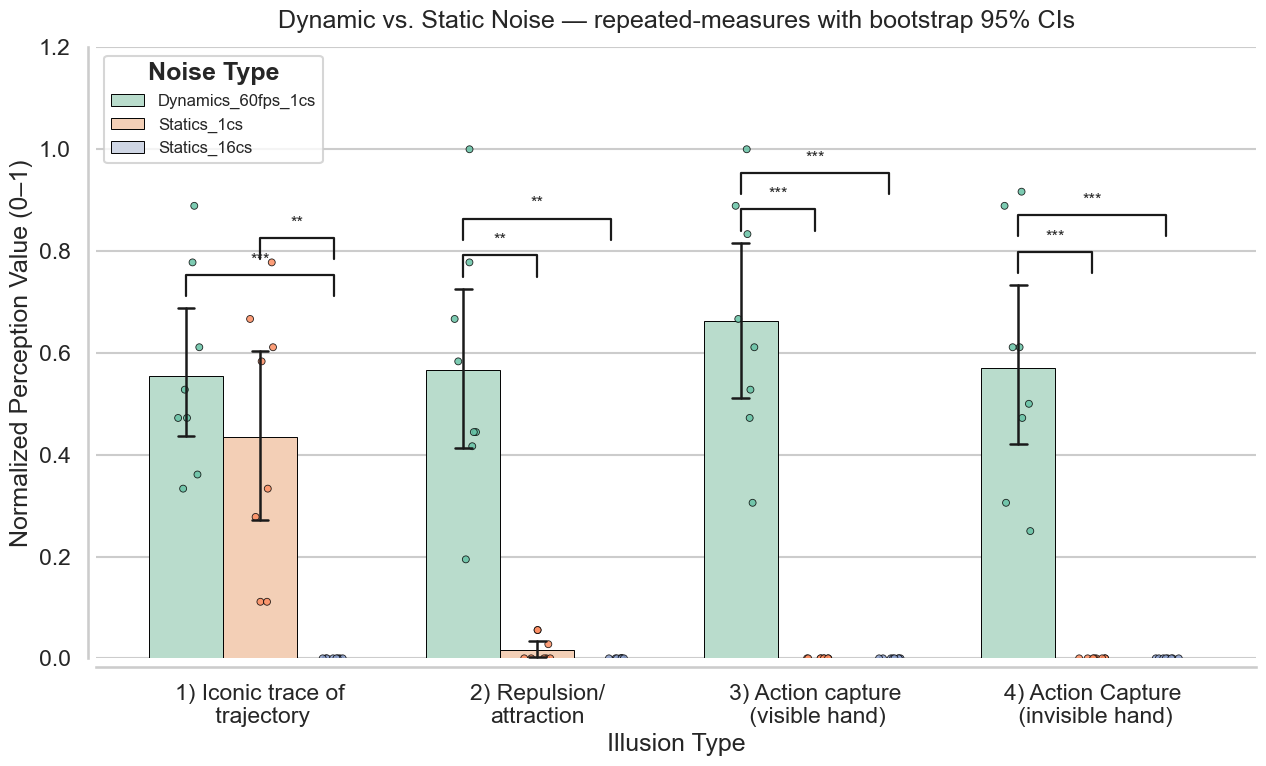

In [4]:
# =========================
# 6) Plot: grouped bars + per-file points + asymmetric bootstrap CIs + brackets
# =========================
sns.set_theme(style="whitegrid", context="talk")
bar_palette   = sns.color_palette("Pastel2", n_colors=len(valid_noise))
point_palette = sns.color_palette("Set2",    n_colors=len(valid_noise))

fig, ax = plt.subplots(figsize=(13, 8))

# Bars (means only; we’ll draw our own error bars)
sns.barplot(
    data=long_df_plot,
    x="illusion", y="value",
    hue="Noise Type",
    order=columns_to_normalize, hue_order=valid_noise,
    errorbar=None,
    edgecolor="black", linewidth=0.7,
    palette=bar_palette,
    ax=ax
)

# Per-file datapoints
sns.stripplot(
    data=long_df_plot,
    x="illusion", y="value",
    hue="Noise Type",
    order=columns_to_normalize, hue_order=valid_noise,
    dodge=True, jitter=0.15,
    alpha=0.85, size=5,
    linewidth=0.6, edgecolor="black",
    palette=point_palette,
    ax=ax, legend=False
)

# X tick labels
xticks = np.arange(len(columns_to_normalize))
ax.set_xticks(xticks, labels=[label_map[ill] for ill in columns_to_normalize], rotation=0)

# Titles / labels
ax.set_title("Dynamic vs. Static Noise — repeated-measures with bootstrap 95% CIs", fontsize=18, pad=14)
ax.set_xlabel("Illusion Type")
ax.set_ylabel("Normalized Perception Value (0–1)")
sns.despine(ax=ax, offset=6)

# Legend
leg = ax.legend(title="Noise Type", loc="upper left", frameon=True, fontsize=12)
leg.get_title().set_weight("bold")

# ---- Draw asymmetric bootstrap CIs (bounded) ----
# Geometry (match seaborn categorical dodge)
x_positions = np.arange(len(columns_to_normalize))
hue_to_index = {g: i for i, g in enumerate(valid_noise)}
n_hue = len(valid_noise)
bar_cluster_width = 0.8
per_hue_offset   = bar_cluster_width / n_hue
def xcoord(ill_idx, group_name):
    j = hue_to_index[group_name]
    return x_positions[ill_idx] + (j - (n_hue - 1) / 2) * per_hue_offset

def draw_asymm_ci(ax, x, mu, lo, hi, cap=0.06):
    if not np.isfinite(mu) or not np.isfinite(lo) or not np.isfinite(hi):
        return
    lo = max(LBOUND, lo); hi = min(UBOUND, hi)
    if hi <= lo:  # nothing to draw
        return
    ax.plot([x, x], [lo, hi], lw=1.8, c='k', zorder=25, clip_on=False)
    ax.plot([x - cap/2, x + cap/2], [hi, hi], lw=1.8, c='k', zorder=25, clip_on=False)
    ax.plot([x - cap/2, x + cap/2], [lo, lo], lw=1.8, c='k', zorder=25, clip_on=False)

top_envelope = []
for i, ill in enumerate(columns_to_normalize):
    for g in valid_noise:
        mu, lo, hi = boot_lookup.get((ill, g), (np.nan, np.nan, np.nan))
        if not np.isfinite(mu): 
            continue
        x = xcoord(i, g)
        draw_asymm_ci(ax, x, mu, lo, hi, cap=0.06)
        top_envelope.append(hi)

# Y-limits with headroom (bounded to [0,1])
if top_envelope:
    ymax_needed = min(UBOUND, max(top_envelope) + 0.10)
    ax.set_ylim(LBOUND, max(0.6, ymax_needed))


# Fix the y-axis to [0, 1]
ax.set_ylim(0.0, 1.2)    

# ---- Significance brackets (paired tests, Holm) ----
ymin, ymax = ax.get_ylim()
yrange = ymax - ymin
BRACKET_H = 0.035 * yrange
STACK_GAP = 0.060 * yrange

def add_bracket(ax, x1, x2, y, text, height, yr):
    y0 = min(y, ymax - 0.02*yr)  # keep inside axis
    ax.plot([x1, x1, x2, x2], [y0, y0 + height, y0 + height, y0],
            lw=1.6, c='k', clip_on=False, zorder=30)
    ax.text((x1 + x2)/2, y0 + height + 0.012*yr, text,
            ha='center', va='bottom', fontsize=12, zorder=31)

for i, ill in enumerate(columns_to_normalize):
    # baseline above tallest (clipped) upper CI for this illusion
    y_candidates = []
    for g in valid_noise:
        mu, lo, hi = boot_lookup.get((ill, g), (np.nan, np.nan, np.nan))
        if np.isfinite(hi):
            y_candidates.append(hi)
    base_y = (max(y_candidates) if y_candidates else 0.9) + 0.02 * yrange

    comp_df = comparisons_by_illusion.get(ill, pd.DataFrame())
    if comp_df.empty: 
        continue
    level = 0
    for g1, g2 in combinations(valid_noise, 2):
        rec = comp_df[((comp_df['group1'] == g1) & (comp_df['group2'] == g2)) |
                      ((comp_df['group1'] == g2) & (comp_df['group2'] == g1))]
        if rec.empty: 
            continue
        stars = str(rec.iloc[0]['stars'])
        if stars == 'n.s.' and not SHOW_NS:
            continue
        x1 = xcoord(i, g1)
        x2 = xcoord(i, g2)
        y  = base_y + level * STACK_GAP
        add_bracket(ax, x1, x2, y, stars, BRACKET_H, yrange)
        level += 1

plt.tight_layout()
plt.savefig("./Dynamics_vs_statics_RM_bootstrapCI.svg", bbox_inches="tight")
plt.show()
